# WIP First integration of the new perception module into the framework

Results below are for commit: ### (Rerunning the code below for other commits is not likely/guaranteed to give the same results.)

* I have now added new optional assumptions `oSNc`, `oSNv`, and `oPF`, as planned in the 2021-10-07 notes.
    * The `oSN*` assumptions introduce the new observation noise standard deviation parameter $\tau$, and `oSNv` also requires the observer's eye height $H_e$ over the ground, which I plan on keeping fixed at 1.5 m for both agent types. The `oPF` assumption also introduces a parameter $\sigma_{\dot{x}}$ for the standard deviation of the speed process noise in the Kalman filter. It also requires priors for position and speed of the other agent, but I consider this rather a scenario parameter than a model parameter (or maybe it should be considered a bit of both I guess).
    * **TODO before finalising this notebook: Document these assumptions in the SCPaper readme.**
* These new assumptions are all implemented in the new class `sc_scenario_perception.Perception`, which also can be configured both to yield the old ideal perception, without any noise or filtering. This has required a number of changes in `SCAgent`, which on the highest level amount to now using `self.perception.perc_oth_state` rather than `self.other_agent.curr_state` as the input to the various behaviour and value calculations in `SCAgent.do_action_update()`. Also changes in `SCAgent.get_predicted_other_state()` and `SCAgent.get_prob_of_current_state_given_beh()`, which previously relied on letting `self.other_agent` do predictions, but which now implement those predictions locally instead, from `self.perception.perc_oth_state`. 
    * See below for various tests verifying that previous behaviour is preserved as it should be when these new assumptions are disabled, but the non-noisy perception is still handled through the new perception class. 
* Overall in this, there remains some awkwardness from my somewhat hacky use of `commotions.KinematicState` in `SCAgent` to also hold `signed_CP_dist`, `cs_entry/exit_time`, and `long_acc` attributes. The hackiness was there already previously, but it now becomes a bit more obvious because I need to convert back and forth a bit between the `signed_CP_dist` representation (which is what `sc_scenario_perception.Perception` operates on, and the `pos` array representation, which is how position was originally supposed to be stored in `commotions.KinematicState`.
    * As one part of this, I moved the `get_signed_dist_to_conflict_pt()` function from being an `SCAgent` method, to being a function in `sc_scenario_helper.py` instead, and also added the converse function `get_pos_from_signed_dist_to_conflict_pt()` there.

In this (intermediate) commit, the `__name__ == "__main__"` code in `sc_scenario.py` runs a scenario and model (`oVAoSNvoPFoEA`) with a parameterisation that generates the sort of deceleration->speedup behaviour that I have had a hard time getting from the deterministic models. **TODO before finalising this notebook: Make sure to properly document this too, with a few probabilistic runs.**

**Maybe also TODO before finalising this notebook: Add an investigation into the "flip-flopping" values estimates with the `oSN*oPF` perception.**

## Init

In [1]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
parent_path = str(Path('.').absolute().parent)
if not (parent_path in sys.path):
    sys.path.append(parent_path)
print(sys.path)

# imports needed to run the simulations
import numpy as np
import commotions
import sc_scenario
from sc_scenario import get_default_params, get_assumptions_dict, SCSimulation
from sc_scenario_helper import CtrlType

['C:\\GITHUB\\COMMOTIONSFramework\\diary notebooks', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\python39.zip', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\DLLs', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64', '', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\Pythonwin', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\tragma\\.ipython', 'C:\\GITHUB\\COMMOTIONSFramework']


## Unit tests, reproducing earlier results

### Basics - check!

Compare to the results in the 2021-10-21 notes. Getting back the same behaviour, so seems ok. 

Just the base model, no interaction.

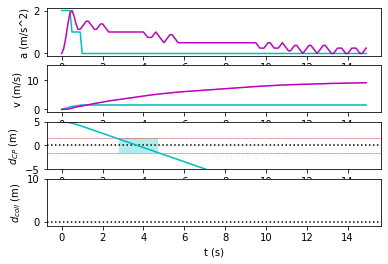

In [2]:
NAMES = ('P', 'V')
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = True, oBEo = False, oBEv = False, oAI = False, oEA = False)
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = NAMES)
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True)

Baseline kinematics, base model. Also ok.

Initial car distance 30 m:


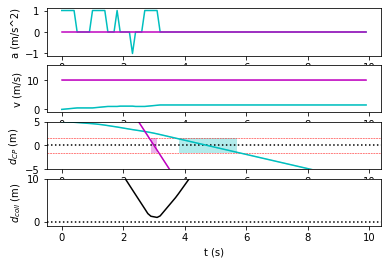

Initial car distance 40 m:


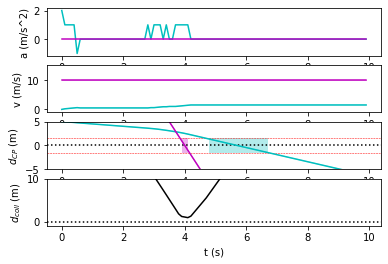

Initial car distance 50 m:


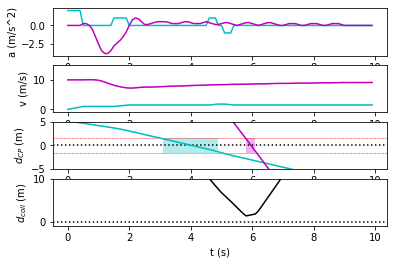

In [3]:
SPEEDS = np.array((0, 10))
PED_Y0 = -5
CONST_ACCS = (None, None)
AFF_VAL_FCN = True
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = False, oBEv = False, oAI = False, oEA = False)
(params, params_k) = sc_scenario.get_default_params(oVA = AFF_VAL_FCN)


def run_baseline_kinematics(dist0s = (30, 40, 50), eff_widths = (None, None),
                            plot_beh_probs = False, plot_beh_activs = False, 
                            plot_beh_accs = False, plot_looming = False, 
                            ped_snaps = None, veh_snaps = None):
    for dist0 in dist0s:
        INITIAL_POSITIONS = np.array([[0, PED_Y0], [dist0, 0]])
        sc_simulation = SCSimulation(
                CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
                end_time = 10, optional_assumptions = optional_assumptions,
                agent_names = NAMES, const_accs = CONST_ACCS, params = params,
                eff_widths = eff_widths, snapshot_times = (ped_snaps, veh_snaps))
        sc_simulation.run()
        print('Initial car distance %d m:' % dist0)
        sc_simulation.do_plots(kinem_states = True, beh_probs = plot_beh_probs,
                              beh_activs = plot_beh_activs, beh_accs = plot_beh_accs,
                              looming = plot_looming)

run_baseline_kinematics()

And here is the same after restoring the pre-safety-margin settings. Again ok.

Initial car distance 30 m:


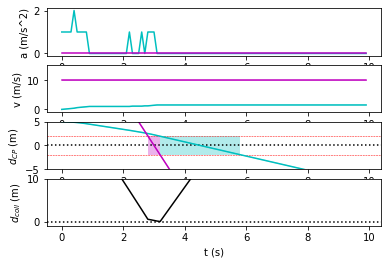

Initial car distance 40 m:


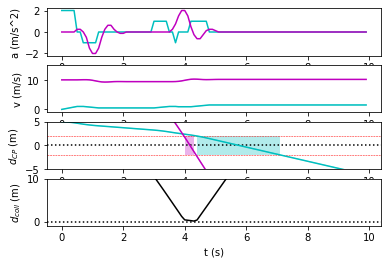

Initial car distance 50 m:


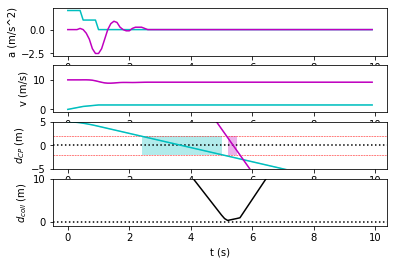

In [4]:
sc_scenario.SHARED_PARAMS.d_C = 2
params.T_s = 0
params.D_s = 0
run_baseline_kinematics()

### The `oBEo` + `oBEv` + `oAI` - almost identical to before

The last time I tested this was 2021-09-16b it seems - so I haven't tested this with the numerically integrated prediction horizon before. The results below are quantitatively not exactly the same as 2021-09-16b, but they are very similar. The small differences might be either from (1) these perception updates (perhaps especially the changes in `SCAgent.get_predicted_other_state()` and `SCAgent.get_prob_of_current_state_given_beh()`, which are mathematically actually more accurate now), (2) the numerical integration introduced 2021-10-21, or (3) some other small difference in code or parameterisation I can't think of now, introduced between 2021-09-16b and 2021-10-21. If it is (2) or (3), the determinstic fits shouldn't be affected. If it is (1), they are likely to be affected. So at some point I should be rerunning the deterministic fits... But maybe best to first make sure to get to a point where I am satisfied I probably won't introduce further changes to the code that is shared by the deterministic and probabilistic fits.

Turning on oBEo:
Initial car distance 40 m:


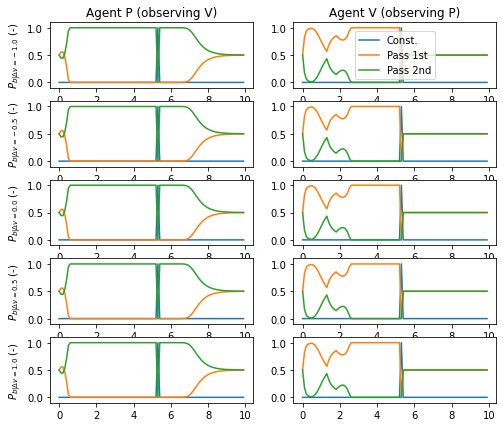

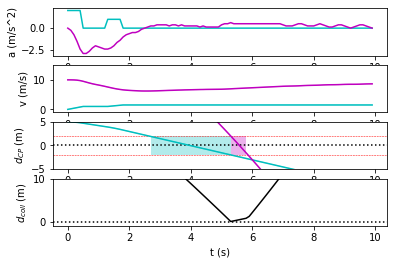

Turning on oBEv:
Initial car distance 40 m:


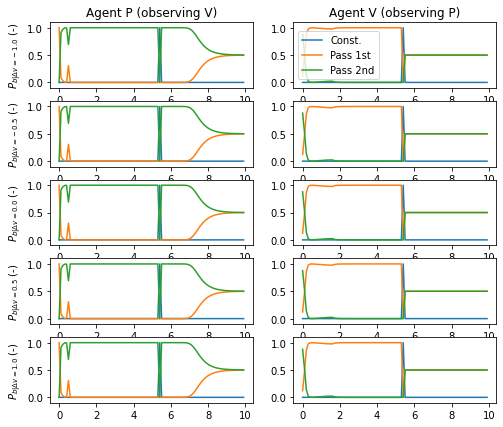

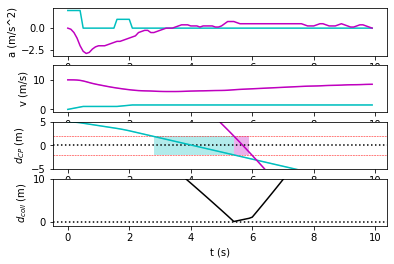

Turning on oAI:
Initial car distance 40 m:


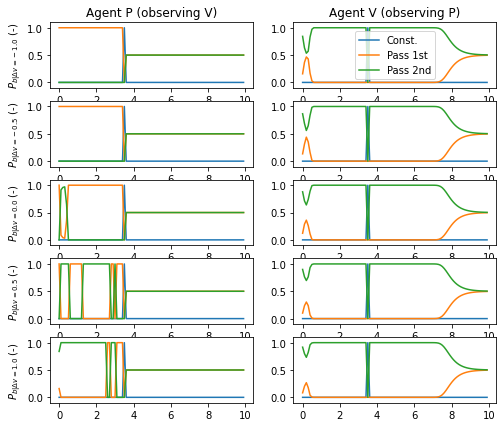

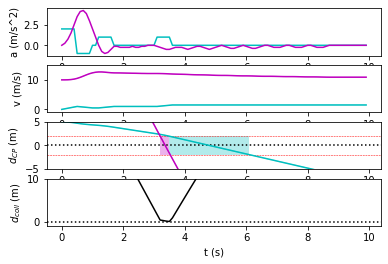

In [5]:
# same settings as in the 2021-09-16b notes (unless there is something else I am forgetting)
params.T_O1 = 0.1 
params.T_Of = 0.5
params.sigma_O = 0.01
params.beta_V = 160

print('Turning on oBEo:')
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = True)
run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
print('Turning on oBEv:')
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = True, oBEv = True)
run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
print('Turning on oAI:')
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = True, oBEv = True, oAI = True)
run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)

### oVAl

This I haven't really tested in any structured way since 2021-10-13, again before I introduced the numerical integration of the prediction horizon. However, we can see that if I disable the numerical integration (`sc_scenario.NEW_AFF_VAL_CALCS = False`) I get back the same results as 2021-10-13 when enabling `oVAL`:

Initial car distance 40 m:


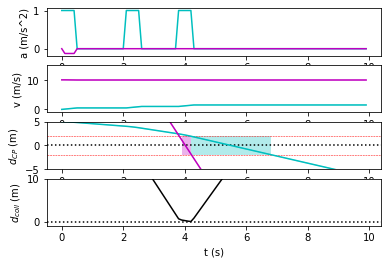

In [6]:
EFF_WIDTHS = (0.8, 1.8)

sc_scenario.NEW_AFF_VAL_CALCS = False
sc_scenario.SHARED_PARAMS.d_C = 2
params.T_s = 0
params.D_s = 0
params.thetaDot_1 = 0.1
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oVAl = True)

run_baseline_kinematics(dist0s=(40,), eff_widths = EFF_WIDTHS)

Now enabling the numerical integration prediction horizon calculations, we see that we get quite different results, but that's expected since `oVAl` is defined completely differently with and without numerical integration (it's the only assumption that's defined differently between these two). In the numerical integration scheme, the looming aversion is counted over the entire horizon, rather than just at the post-action time point, so to get something comparable we need to reduce the value of the $\dot{\theta}_1$ parameter substantially, but then it actually looks quite similar to above:

thetaDot_1 = 0.1 rad/s


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:216: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:216: RuntimeWarning: invalid value encountered in true_divide
  side_app_arr_times = side_dists / speeds


Initial car distance 40 m:


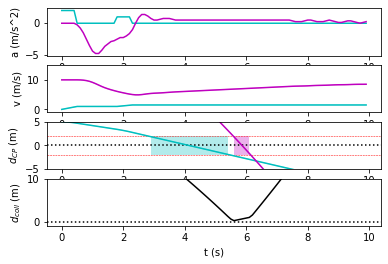

thetaDot_1 = 0.005 rad/s


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:216: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:216: RuntimeWarning: invalid value encountered in true_divide
  side_app_arr_times = side_dists / speeds


Initial car distance 40 m:


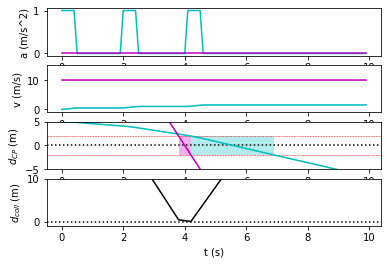

In [7]:
sc_scenario.NEW_AFF_VAL_CALCS = True

for params.thetaDot_1 in (0.1, 0.005):
    print(f'thetaDot_1 = {params.thetaDot_1} rad/s')
    run_baseline_kinematics(dist0s=(40,), eff_widths = EFF_WIDTHS)

## Conclusions

*  At some point I should be rerunning the deterministic fits... But maybe best to first make sure to get to a point where I am satisfied I probably won't introduce further changes to the code that is shared by the deterministic and probabilistic fits. Added to todolist in SCPaper README.